# Traffic Density VS Football Matches
    Joseph Antony
    19th June 2023

In [1]:
import warnings
import numpy as np

from datetime import datetime, timedelta

import polars as pl
pl.enable_string_cache(True)

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="ticks", palette="muted", color_codes=True)

warnings.filterwarnings("ignore")

plt.rcParams['axes.labelsize'] = 15
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['font.weight'] = "bold"

In [2]:
football_leagues = (
    pl.read_csv("datasets/05_tr_football_matches/tr_ist_2019_2023_football_matches.csv")
    .select(['date', 'stadium', 'league'])
    .with_columns(pl.col('date').str.to_datetime(time_unit='ns').dt.round("-1h"))
    .join(
        pl.read_csv("datasets/13_gh_proximities/gh_nearby_stadiums.csv")
        .filter(pl.col('type').eq('geohash'))
        .select(['name', 'nearest'])
        .rename({'nearest' : 'stadium', 'name' : 'GEOHASH'}),
        on='stadium'
        )
    .with_columns(pl.col(['stadium', 'league', 'GEOHASH']).cast(pl.Categorical))
    .rename({'date' : 'DATE_TIME'})
)

football_leagues.head()

DATE_TIME,stadium,league,GEOHASH
datetime[ns],cat,cat,cat
2019-08-07 21:00:00,"""BAŞAKŞEHİR FAT…","""UEFA Champions…","""sxk3zw"""
2019-08-07 21:00:00,"""BAŞAKŞEHİR FAT…","""UEFA Champions…","""sxk3zt"""
2019-08-07 21:00:00,"""BAŞAKŞEHİR FAT…","""UEFA Champions…","""sxk3zx"""
2019-08-18 22:00:00,"""RECEP TAYYİP E…","""Spor Toto Supe…","""sxk97m"""
2019-08-18 22:00:00,"""RECEP TAYYİP E…","""Spor Toto Supe…","""sxk97q"""


In [3]:
select_Cols = [
    'DATE_TIME', 'GEOHASH', 'DISTRICT', 'NUMBER_OF_VEHICLES', 'IS_FOOTBALL_MATCH'
]

pl_df = (
    pl.scan_parquet("datasets/00_tr_df_merged/tr_ist_td_merged_full.zstd")
    .select(select_Cols,
            pl.col('DATE_TIME').dt.hour().alias('HOUR').cast(pl.UInt8),
            pl.col('DATE_TIME').dt.weekday().alias('DAYOFWEEK').cast(pl.UInt8),
            pl.col('DATE_TIME').dt.month().alias('MONTH').cast(pl.UInt8),
            pl.col('DATE_TIME').dt.date().alias('DATE'),
            pl.col('DATE_TIME').dt.year().alias('YEAR').cast(pl.UInt16))

    .join(football_leagues.lazy(), on=['GEOHASH', 'DATE_TIME'], how='left')
    .with_columns(pl.col('stadium').fill_null('no_stadium'),
                  pl.col('league').fill_null('no_league'))
).collect(streaming=True)

pl_df.head()

DATE_TIME,GEOHASH,DISTRICT,NUMBER_OF_VEHICLES,IS_FOOTBALL_MATCH,HOUR,DAYOFWEEK,MONTH,DATE,YEAR,stadium,league
datetime[ns],cat,cat,u16,bool,u8,u8,u8,date,u16,cat,cat
2020-01-01 00:00:00,"""sxkbj3""","""Gebze""",97,false,0,3,1,2020-01-01,2020,"""no_stadium""","""no_league"""
2020-01-01 01:00:00,"""sxkbj3""","""Gebze""",58,false,1,3,1,2020-01-01,2020,"""no_stadium""","""no_league"""
2020-01-01 02:00:00,"""sxkbj3""","""Gebze""",40,false,2,3,1,2020-01-01,2020,"""no_stadium""","""no_league"""
2020-01-01 03:00:00,"""sxkbj3""","""Gebze""",33,false,3,3,1,2020-01-01,2020,"""no_stadium""","""no_league"""
2020-01-01 04:00:00,"""sxkbj3""","""Gebze""",25,false,4,3,1,2020-01-01,2020,"""no_stadium""","""no_league"""


In [4]:
gh_stad_dict = (
    pl.read_csv("datasets/13_gh_proximities/gh_nearby_stadiums.csv")
    .filter(pl.col('type').eq('geohash'))
    .select(['name', 'nearest'])
    .to_pandas()
    .set_index('name')
    .rename(columns={'nearest' : 'stadium'})
    .loc[:, 'stadium']
    .to_dict()
)

gh_stad_dict

{'sxk3zw': 'BAŞAKŞEHİR FATİH TERİM',
 'sxk3zt': 'BAŞAKŞEHİR FATİH TERİM',
 'sxk3zx': 'BAŞAKŞEHİR FATİH TERİM',
 'sxk97m': 'RECEP TAYYİP ERDOĞAN STADYUMU',
 'sxk97q': 'RECEP TAYYİP ERDOĞAN STADYUMU',
 'sxk97j': 'RECEP TAYYİP ERDOĞAN STADYUMU',
 'sxk97n': 'RECEP TAYYİP ERDOĞAN STADYUMU',
 'sxk97k': 'RECEP TAYYİP ERDOĞAN STADYUMU',
 'sxk9hv': 'ÜLKER STADYUMU',
 'sxk9ht': 'ÜLKER STADYUMU',
 'sxk9hy': 'ÜLKER STADYUMU',
 'sxk9hw': 'ÜLKER STADYUMU',
 'sxk9hu': 'ÜLKER STADYUMU',
 'sxk97z': 'VODAFONE PARK',
 'sxk97y': 'VODAFONE PARK',
 'sxk97x': 'VODAFONE PARK',
 'sxk97w': 'VODAFONE PARK',
 'sxk9gd': 'NEF STADYUMU',
 'sxk9ge': 'NEF STADYUMU',
 'sxk9gf': 'NEF STADYUMU',
 'sxk9g9': 'NEF STADYUMU',
 'sxk9gg': 'NEF STADYUMU',
 'sxk3wt': 'ATATÜRK OLİMPİYAT',
 'sxk3ws': 'ATATÜRK OLİMPİYAT',
 'sxk3ww': 'ATATÜRK OLİMPİYAT',
 'sxk3ku': 'NECMİ KADIOĞLU',
 'sxk3kg': 'NECMİ KADIOĞLU',
 'sxk9w6': 'ÜMRANİYE STADYUMU',
 'sxk9w7': 'ÜMRANİYE STADYUMU'}

In [42]:
len(np.unique([v for v in gh_stad_dict.values()]))

8

In [43]:
len(np.unique([v for v in gh_stad_dict.keys()]))

29

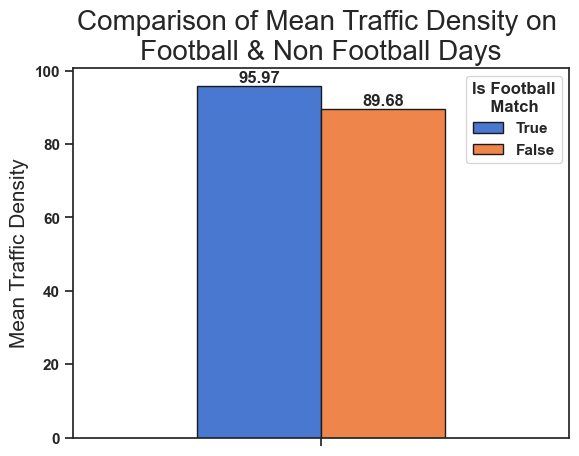

In [5]:
ax = (
    pl_df.lazy()
    .groupby('IS_FOOTBALL_MATCH')
    .agg(pl.col('NUMBER_OF_VEHICLES').mean())
    .collect(streaming=True)
    .to_pandas()
    .set_index('IS_FOOTBALL_MATCH').T
    .plot(kind='bar', edgecolor='k', rot=0, title="Comparison of Mean Traffic Density on \nFootball & Non Football Days")
)

ax.set_xticklabels("")
ax.set_ylabel("Mean Traffic Density")
ax.legend(ncol=1, title='Is Football\n    Match', loc='upper right');

for c in ax.containers:
    labels = [np.round(v, 2) for v in c.datavalues]    
    ax.bar_label(c, labels=labels, label_type="edge", fontweight = "bold")

    Mean Traffic density are higher during football matches.

In [6]:
def plot_temporal_pattern(temporal_col, title):

    temp_df = (
        pl_df.lazy()
        .filter(pl.col('IS_FOOTBALL_MATCH').eq('true'))
        .groupby(temporal_col)
        .agg(pl.col('NUMBER_OF_VEHICLES').mean())
        .sort(temporal_col)
        .collect(streaming=True)
        .to_pandas()
        .set_index(temporal_col)
    )

    ax = sns.barplot(
        x=temp_df.index,
        y=temp_df['NUMBER_OF_VEHICLES'],
        hue=temp_df['NUMBER_OF_VEHICLES'],
        dodge=False,
        edgecolor='k',
        palette="viridis_r"
    )

    for c in ax.containers:
        labels = [np.round(v, 2) for v in c.datavalues]    
        ax.bar_label(c, labels=labels, label_type="edge", fontweight = "bold")

    ax.set_title(title)
    ax.legend().remove()

    if temporal_col=='DAYOFWEEK':
        weekday_labels=["mon", "tue", "wed", "thur", "fri", "sat", "sun"]
        ax.set_xticks(range(7), labels=weekday_labels)

    if temporal_col=='MONTH':
        month_labels=['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
        ax.set_xticks(ticks=np.arange(12), labels=month_labels)
    
    plt.show();

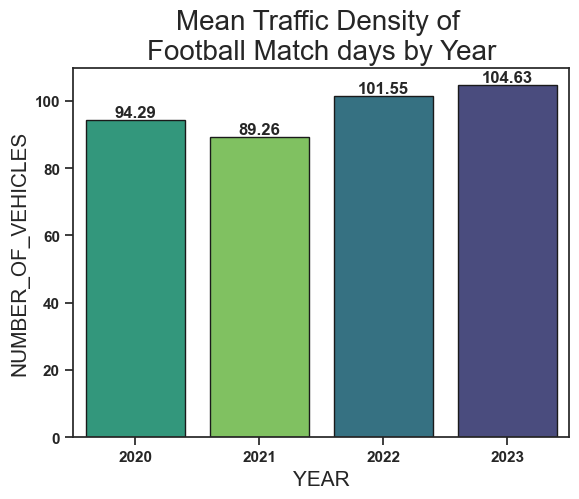

In [7]:
plot_temporal_pattern(temporal_col='YEAR', title='Mean Traffic Density of \nFootball Match days by Year')

    Mean Traffic Density during a match day were lower during 2020 and 2021. This is most probably attributed to COVID restrictions. Since 2022, the mean traffic density has been increasing again.

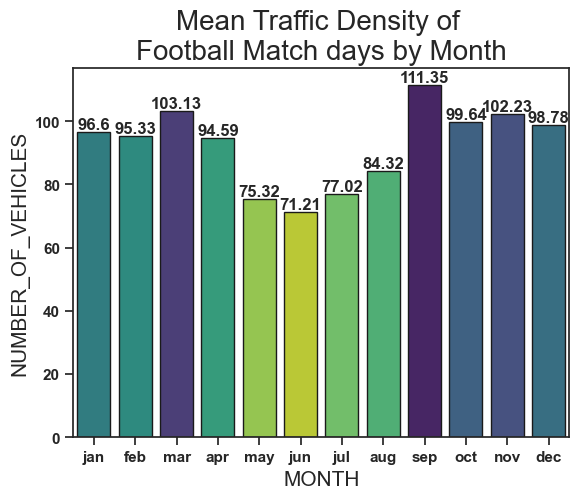

In [8]:
plot_temporal_pattern(temporal_col='MONTH', title='Mean Traffic Density of \nFootball Match days by Month')

    Football matches during March and September sees the highest mean traffic densities.

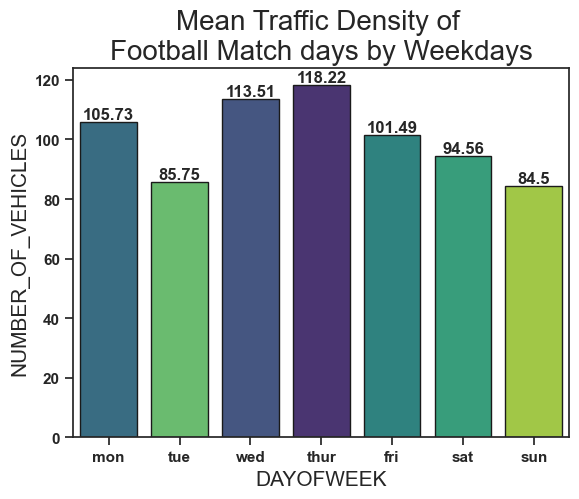

In [9]:
plot_temporal_pattern(temporal_col='DAYOFWEEK', title='Mean Traffic Density of \nFootball Match days by Weekdays')

    Football Matches during Wednesay or Thursday sees the highest traffic density.

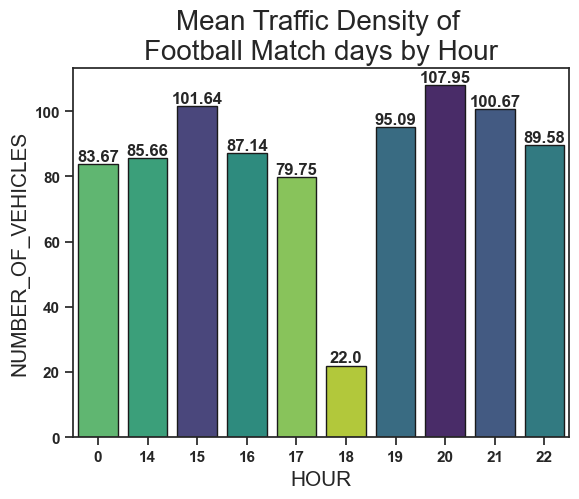

In [10]:
plot_temporal_pattern(temporal_col='HOUR', title='Mean Traffic Density of \nFootball Match days by Hour')

    On days where there is a Football match, hours at 3pm and between 7pm to 8pm sees a higher traffic density.

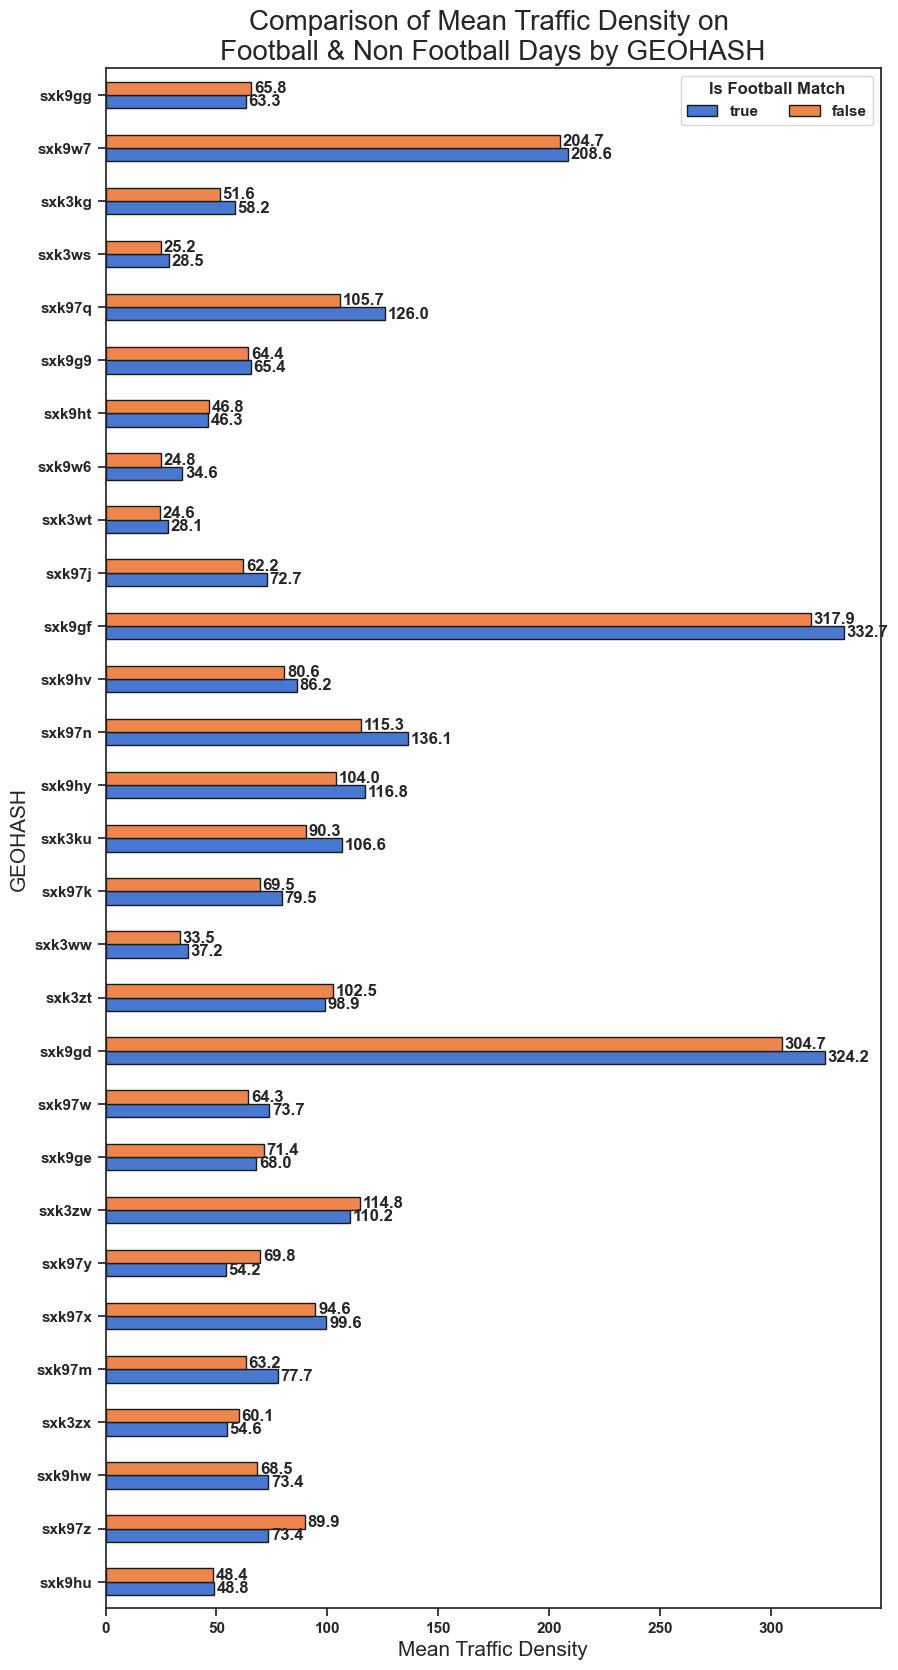

In [11]:
ax = (
    pl_df.lazy()
    .filter(pl.col('GEOHASH').is_in(list(gh_stad_dict.keys())))
    .groupby(['GEOHASH', 'IS_FOOTBALL_MATCH'])
    .agg(pl.col('NUMBER_OF_VEHICLES').mean())
    .collect(streaming=True)
    .pivot(index='GEOHASH', columns='IS_FOOTBALL_MATCH', values='NUMBER_OF_VEHICLES')
    .select(['GEOHASH', 'true', 'false'])
    .to_pandas()
    .set_index('GEOHASH')
    .plot(kind='barh', figsize=(10, 20), edgecolor='k', 
          title="Comparison of Mean Traffic Density on \nFootball & Non Football Days by GEOHASH")
)

ax.legend(title='Is Football Match', ncol=2, loc="upper right")
ax.set_xlabel("Mean Traffic Density")

for c in ax.containers:
    labels = [np.round(v, 1) for v in c.datavalues]    
    ax.bar_label(c, labels=labels, label_type="edge", fontweight = "bold", padding=2);

    This barplot shows all GEOHASH's which has a stadium within its 1km radius. For each GEOHASH, mean traffic density based on being a match day or not is shown. Although for most GEOHASH, mean TD is high during a match day, there are handful of GEOHASH where this is not the case.

## Daily Traffic Density Timeline with Football Matches

In [12]:
(
    pl_df.lazy()
    .filter(pl.col('IS_FOOTBALL_MATCH').eq('true'))
    .groupby(['DISTRICT', 'GEOHASH'])
    .agg(pl.col('NUMBER_OF_VEHICLES').max())
    .sort(['DISTRICT', 'NUMBER_OF_VEHICLES'], descending=True)
    .with_columns(pl.col('NUMBER_OF_VEHICLES').rank('dense', descending=True).over('DISTRICT').alias('TD_row'))
    .filter(pl.col('TD_row').eq(1))
    .drop('TD_row')
    .sort('NUMBER_OF_VEHICLES')
    .collect(streaming=True)
)

DISTRICT,GEOHASH,NUMBER_OF_VEHICLES
cat,cat,u16
"""Ümraniye""","""sxk9w6""",46
"""Beşiktaş""","""sxk97z""",119
"""Kâğıthane""","""sxk9g9""",130
"""Esenyurt""","""sxk3ku""",164
"""Şişli""","""sxk97x""",176
"""Kadıköy""","""sxk9hy""",180
"""Beyoğlu""","""sxk97n""",210
"""Başakşehir""","""sxk3zw""",232
"""Beykoz""","""sxk9w7""",249


In [13]:
def plot_td_scatter(gh):

    stadium = gh_stad_dict[gh]

    cmp = {"false" : 'b', "true" : 'red'}

    temp_df = (
    pl_df.lazy()
    .filter(pl.col('GEOHASH').eq(gh))
    .groupby(['DATE', 'IS_FOOTBALL_MATCH'])
    .agg(pl.col('NUMBER_OF_VEHICLES').mean())
    .sort('DATE')
    .collect(streaming=True)
    .pivot(index=['DATE'], columns='IS_FOOTBALL_MATCH', values='NUMBER_OF_VEHICLES')
    .to_pandas()
    .set_index('DATE')
)

    ax = temp_df.plot(linestyle="", marker='o', color=cmp, mec='k', alpha=0.7, figsize=(12, 5))

    limits = [temp_df['false'].min(), temp_df['false'].max(), temp_df['true'].max(), temp_df['true'].min()]

    min_val=min(limits)-10
    max_val=max(limits)+10

    # Areas representing COVID time period are shaded in red
    ax.fill_between(x=("2020-03-01", "2020-05-31"), y1=min_val, y2=max_val, color='r', alpha = 0.5)
    ax.fill_between(x=("2020-11-20", "2021-02-28"), y1=min_val, y2=max_val, color='r', alpha = 0.5)
    ax.fill_between(x=("2021-03-30", "2021-05-31"), y1=min_val, y2=max_val, color='r', alpha = 0.5)
    
    ax.legend(title="Is Football Match", ncol=2, loc='lower right')
    ax.set_title(f"Daily TD - {gh} (near {stadium.title()})")
    ax.set_ylabel("Mean Number of Vehicles")
    ax.set_xlabel("")

    plt.show();

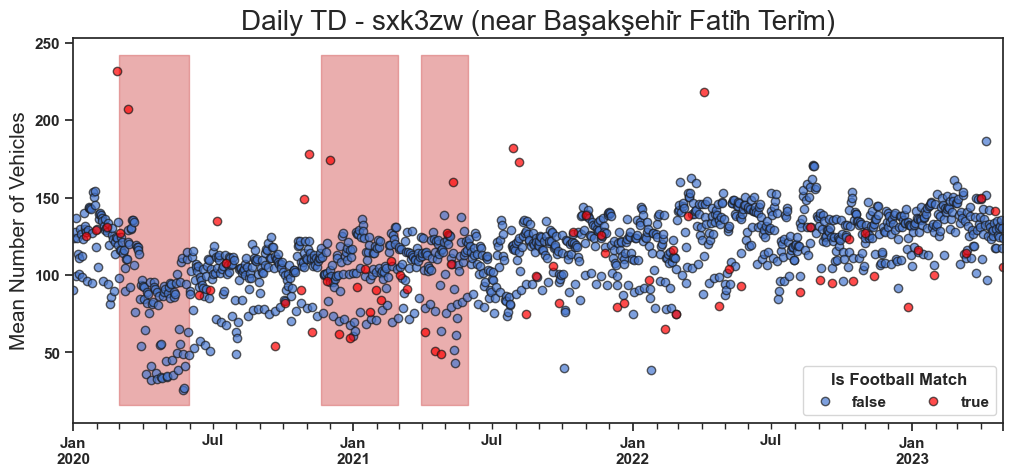

In [14]:
# "Başakşehir"
plot_td_scatter(gh='sxk3zw')

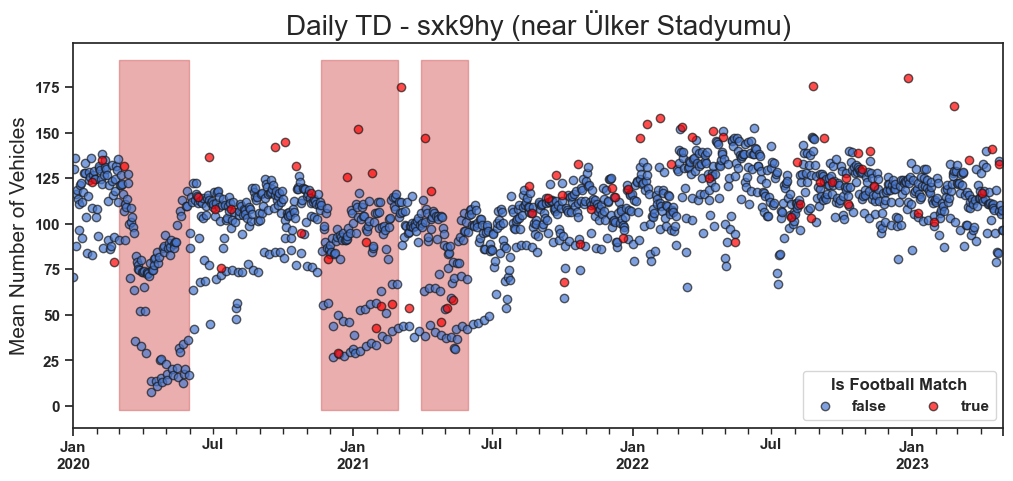

In [15]:
# Kadıköy
plot_td_scatter(gh='sxk9hy')

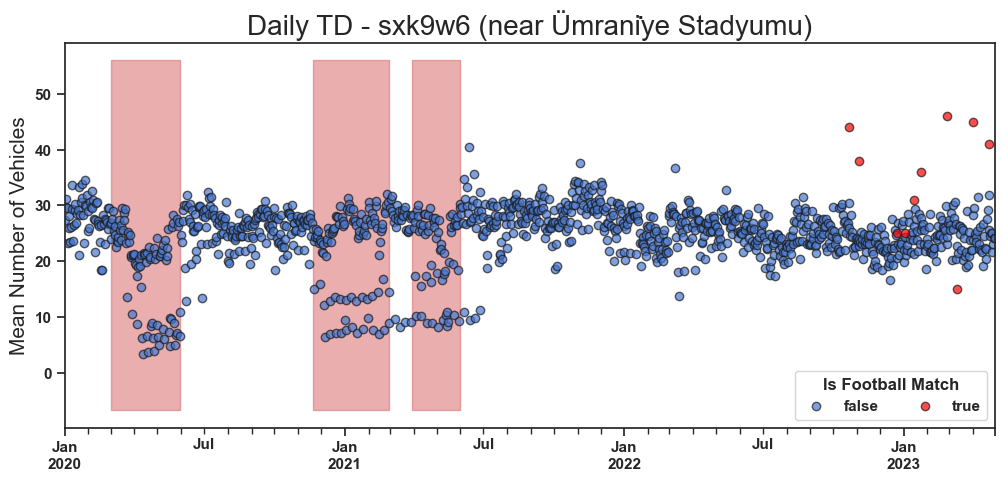

In [16]:
# Umraniye stadium
plot_td_scatter(gh='sxk9w6')

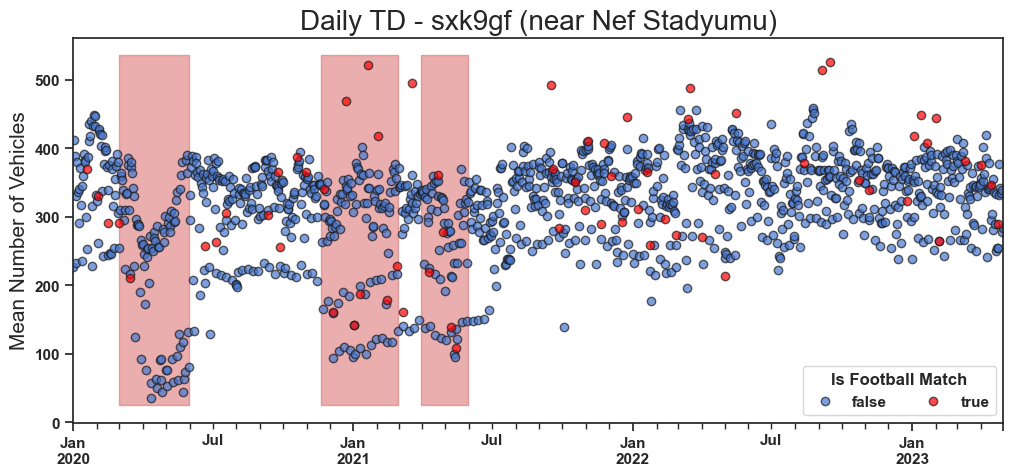

In [17]:
# Sarıyer
plot_td_scatter(gh='sxk9gf')

    The plots above shows the daily mean traffic density for a GEOHASH with the highest mean TD. The red points represents football match days. Overall, mean daily traffic density seems to be highest when there is a football match, as is obvious in these plots.

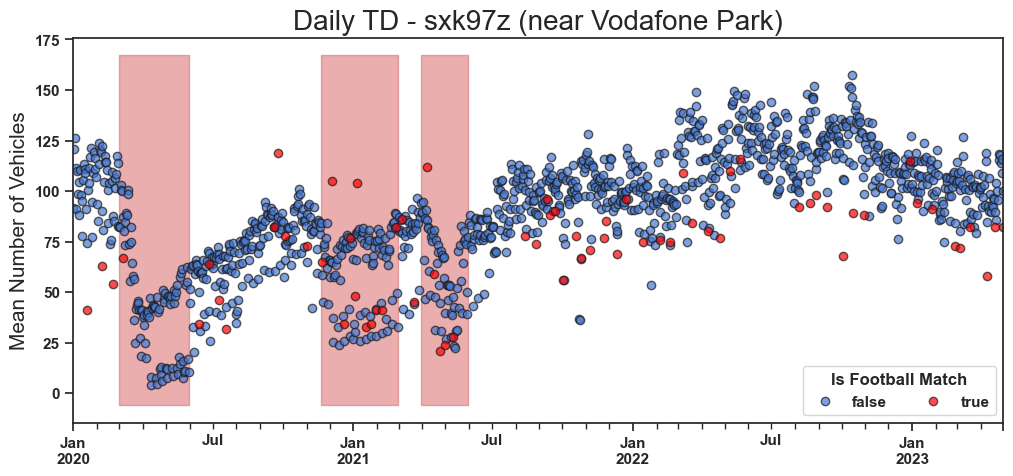

In [18]:
# Beşiktaş
plot_td_scatter(gh='sxk97z')

    As mentioned earlier, not all GEOHASH sees a higher traffic density during match days, as seen in the plot above.

#### Looking closely at the above plots, not all football matches causes higher traffic density. Probably the ones that are important matches such as kick off matches, semi-finals, finals etc. might the matches causing high traffic density.

# Hour Pattern

In [19]:
def plot_match_hours(gh, date):

    # Creating dateobject
    match_date = datetime.strptime(date, '%Y-%m-%d').date()

    # DF with hourly traffic density in Match day    
    match_df = (
        pl_df
        .filter(pl.col('GEOHASH').eq(gh) &
                pl.col('DATE').eq(match_date))
        .select(['DATE_TIME', 'NUMBER_OF_VEHICLES', 'IS_FOOTBALL_MATCH'])
        .to_pandas()
        .set_index('DATE_TIME')
    )

    # stadium
    try:
        stadium = gh_stad_dict[gh]
    except:
        stadium=""

    # Creating y axis limits    
    y1=match_df['NUMBER_OF_VEHICLES'].min()-2
    y2=match_df['NUMBER_OF_VEHICLES'].max()+2

    # Get the date and hour when match took place.    
    match_start_time=match_df.loc[match_df['IS_FOOTBALL_MATCH']].index[0]
    
    # Creating x axis limits for shading 2 hours before and 2 hours after match starts
    x1 = match_start_time - timedelta(hours=2)
    x2 = match_start_time + timedelta(hours=2)
  

    # Plotting match day Time series    
    ax = match_df.plot(y='NUMBER_OF_VEHICLES', figsize=(8, 3), lw='2', marker='o', 
                       mfc='g', mec='k', color='k', legend=False, 
                       title=f"{gh} Hourly TD on {date} \n({match_date.strftime('%A')}, {stadium.title()})")
        
    # Indicate at what time did the match start
    ax.axvline(match_start_time, color='red', linestyle='--')

    # Add a text at the time when match starts
    ax.text(x=match_start_time, y=y1+10, s='Match Start Hour', color='brown',
            rotation='vertical', horizontalalignment='right')


    # Shade areas 2 hrs before and 2 hrs after match starts   
    ax.fill_between(x=(x1, x2), y1=y1, y2=y2, color='r', alpha=0.5)

    plt.show();

In [20]:
gh_near_stadiums = (
    pl_df.lazy()
    .filter(pl.col('IS_FOOTBALL_MATCH').eq('true'))
    .groupby(['DISTRICT', 'GEOHASH'])
    .agg(pl.col('NUMBER_OF_VEHICLES').max())
    .sort(['DISTRICT', 'NUMBER_OF_VEHICLES'], descending=True)
    .with_columns(pl.col('NUMBER_OF_VEHICLES').rank('dense', descending=True).over('DISTRICT').alias('TD_row'))
    .filter(pl.col('TD_row').eq(1))
    .select('GEOHASH')
    .collect(streaming=True)
    .to_series()
    .to_list()
)

gh_near_stadiums

['sxk97z',
 'sxk97n',
 'sxk97x',
 'sxk9w7',
 'sxk9g9',
 'sxk9w6',
 'sxk9hy',
 'sxk3ku',
 'sxk9gf',
 'sxk3zw']

In [21]:
(
    pl_df.lazy()
    .filter(pl.col('GEOHASH').is_in(gh_near_stadiums) &
            pl.col('IS_FOOTBALL_MATCH').eq('true'))
    .groupby(['GEOHASH', 'DATE'])
    .agg(pl.col('NUMBER_OF_VEHICLES').max())
    .sort(['GEOHASH', 'NUMBER_OF_VEHICLES'], descending=True)
    .with_columns(pl.col('NUMBER_OF_VEHICLES').rank('dense', descending=True).over('GEOHASH').alias('TD_row'))
    .filter(pl.col('TD_row').eq(1))
    .sort('NUMBER_OF_VEHICLES')
    .collect(streaming=True)
)

GEOHASH,DATE,NUMBER_OF_VEHICLES,TD_row
cat,date,u16,u32
"""sxk9w6""",2023-02-26,46,1
"""sxk97z""",2020-09-24,119,1
"""sxk9g9""",2022-09-16,130,1
"""sxk3ku""",2020-10-30,164,1
"""sxk97x""",2022-09-12,176,1
"""sxk9hy""",2022-12-27,180,1
"""sxk97n""",2022-10-15,210,1
"""sxk3zw""",2020-02-27,232,1
"""sxk9w7""",2023-02-26,249,1


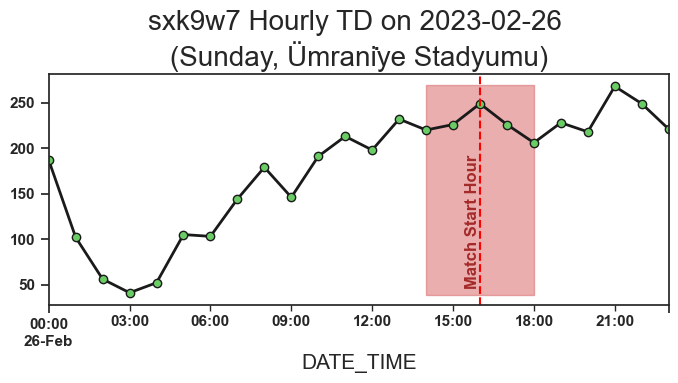

In [22]:
plot_match_hours(gh='sxk9w7', date='2023-02-26')

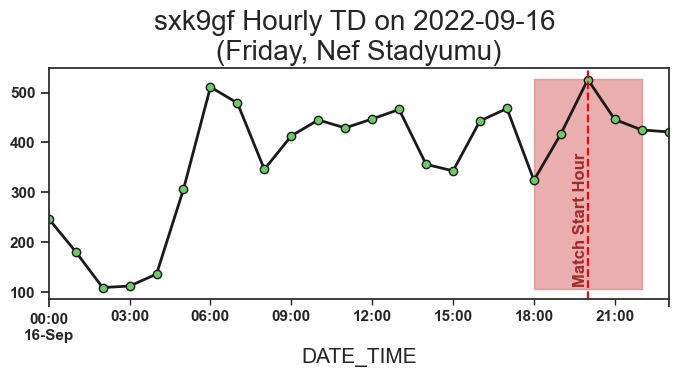

In [23]:
plot_match_hours(gh='sxk9gf', date='2022-09-16')

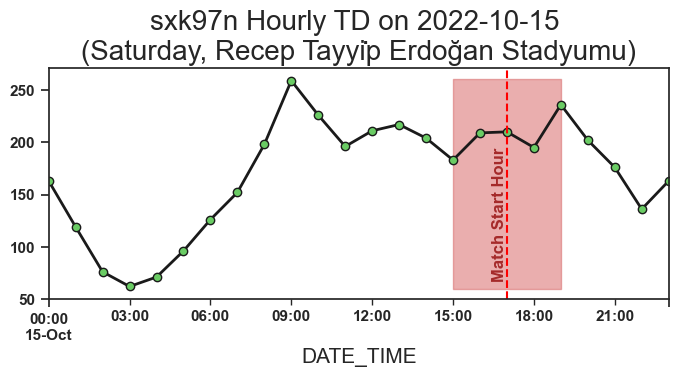

In [24]:
plot_match_hours(gh='sxk97n', date='2022-10-15')

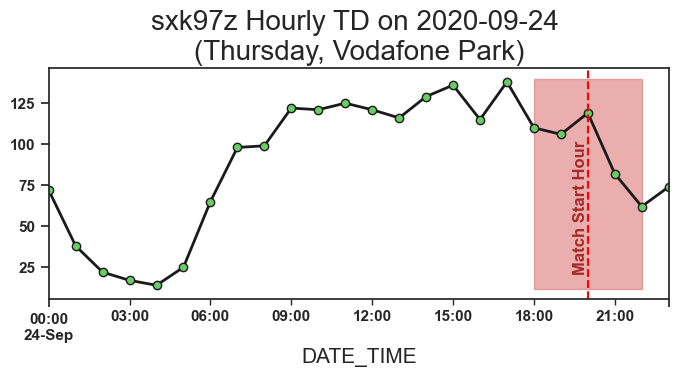

In [25]:
plot_match_hours(gh='sxk97z', date='2020-09-24')

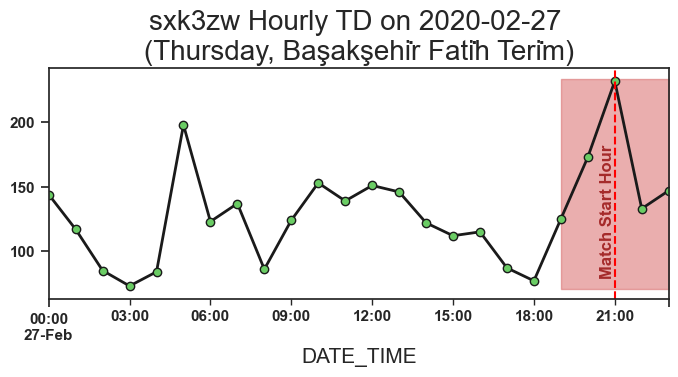

In [26]:
plot_match_hours(gh='sxk3zw', date='2020-02-27')

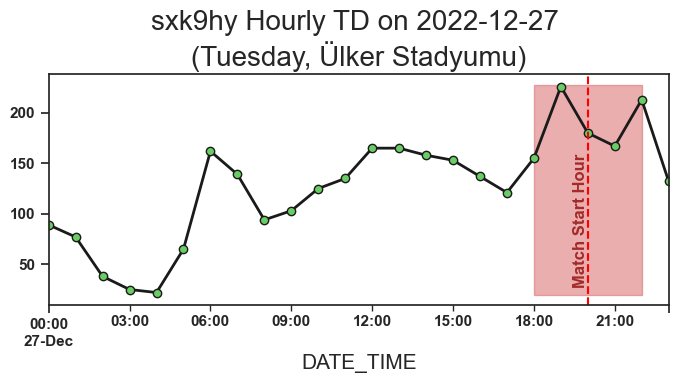

In [27]:
plot_match_hours(gh='sxk9hy', date='2022-12-27')

    The above 3 plots shows the hourly timeline of traffic density during a match day. The red shaded area represents 2 hours before and after a match starting hour. The red dashed line is the hour when a match started. There is an uptick in traffic density during the hourswhen a match starts.

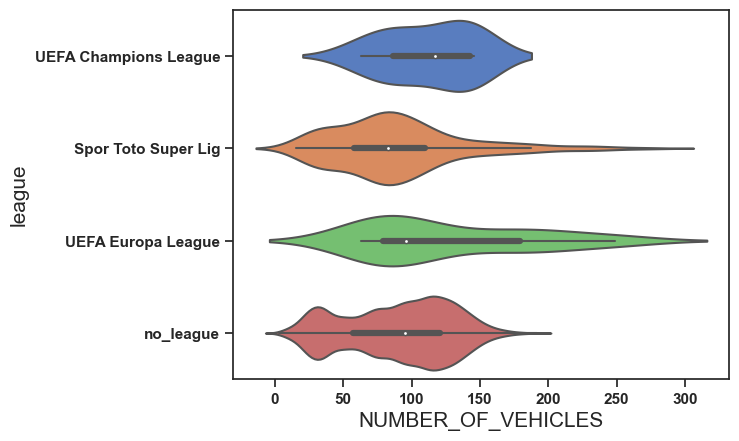

In [28]:
sns.violinplot(
    x='NUMBER_OF_VEHICLES',
    y='league',
    data=(
        pl_df.lazy()
        .groupby(['league', 'DATE_TIME'])
        .agg(pl.col('NUMBER_OF_VEHICLES').mean())
        .collect(streaming=True)
        .to_pandas()
    ),
    orient='h'
);

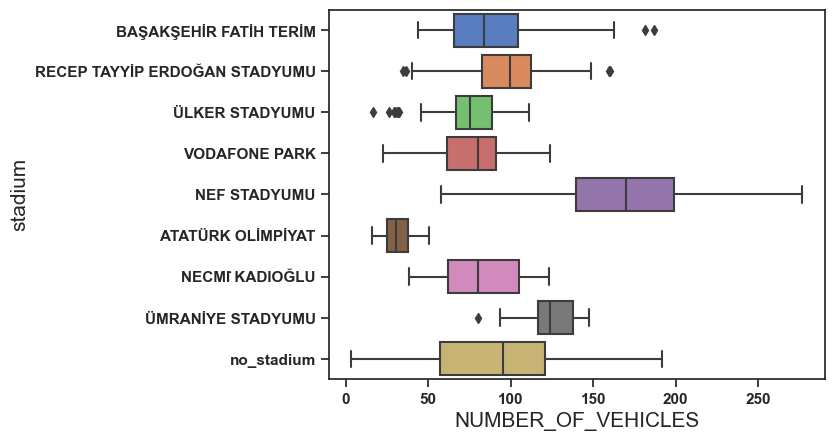

In [29]:
sns.boxplot(
    x='NUMBER_OF_VEHICLES',
    y='stadium',
    data=(
        pl_df.lazy()
        .groupby(['stadium', 'DATE_TIME'])
        .agg(pl.col('NUMBER_OF_VEHICLES').mean())
        .collect(streaming=True)
        .to_pandas()
    ),
    orient='h',
    dodge=False
);

In [30]:
def plot_td_league(gh):

    stadium = gh_stad_dict[gh]

    temp_df = (
        pl_df.lazy()
        .filter(pl.col('GEOHASH').eq(gh))
        .groupby(['DATE', 'league'])
        .agg(pl.col('NUMBER_OF_VEHICLES').mean())
        .sort('DATE')
        .collect(streaming=True)
        .pivot(index=['DATE'], columns='league', values='NUMBER_OF_VEHICLES')
        .to_pandas()
        .set_index('DATE')
    )

    ax = temp_df.plot(linestyle="", marker='o', mec='k', figsize=(12, 5))
    
    ax.legend(title="Football Leagues", ncol=4, loc='lower center', bbox_to_anchor=(0.5, -0.3))
    ax.set_title(f"Daily TD - {gh} (near {stadium.title()})")
    ax.set_ylabel("Mean Number of Vehicles")
    ax.set_xlabel("")

    plt.show();

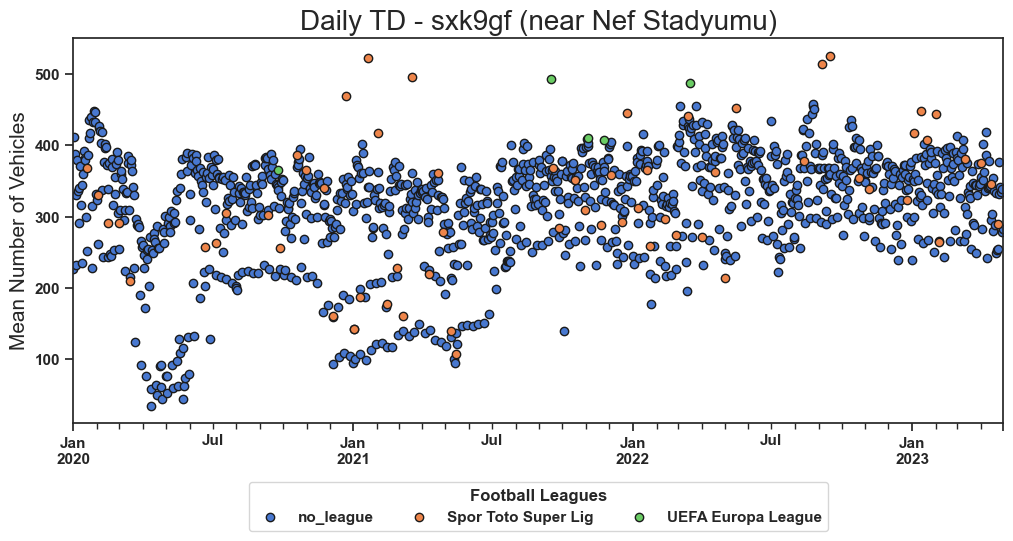

In [56]:
plot_td_league('sxk9gf')